<a href="https://colab.research.google.com/github/operixon/mlsg-kaggle/blob/master/mouseprobe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importy

In [ ]:
import pandas as pd
import glob
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt  # To visualize
from sklearn.linear_model import LinearRegression


# Zmienne globalne

# Dane

Głównym źródłem danych jest projekt na github https://github.com/operixon/mouseml
Składa się on z plików z danymi csv zawierającymi 3 kolumny:
- czas w milisekundach od rozpoczęcia sesji
- pozycja x
- pozycja y

Właściwe dane znajdują się w katalogach
test1/local/clean - sesja lokalna nagrano ruchy właściciela
test1/remote/clean - sesja zdalna nagrano ruchy osoby podłączonej zdalnym pulpitem

Sesje lokalne i zdalne następowały po sobie tak aby zasymulować dokładny przebieg przejęcia.


## Pobranie danych z git

In [ ]:
%%bash
rm -rf mouseml
git clone https://github.com/operixon/mouseml.git


Cloning into 'mouseml'...


In [ ]:
!ls mouseml/test1/local/clean
!ls mouseml/test1/remote/clean

t1-artur-local-session-1.txt  t1-konrad-local-session-1-touhpad.txt
t1-artur-local-session-2.txt  t1-konrad-local-session-2-mouse.txt
t1-artur-remote-msteams-session1.txt  t1-konrad-remote-msteams-session1.txt
t1-artur-remote-msteams-session2.txt  t1-konrad-remote-msteams-session2.txt


## Czytanie danych 

- czytanie plików w katalogach (t x y)
- generowanie kolumn z cechami dx, dy, dt, liczba próbek w oknie, parametry statystyczne dla okna
- usuniecie wszystkich wierszy zawierających nule
- ustawienie indeksu jako kolumny zawierajacej timestamp
- sid : identyfikator sesji : a1, a2, k1, k2
- session : typ sesji remote , local
- file : nazwa pliku z danymi

---

- output : **mpd** ( dataframe zawierający oznaczone sesje )

In [ ]:
#TODO : przewijanie indexu do 0. Niektóre serie zaczynaja się np od 5 minuty
def preprocess(df):
  d = df#.copy()
 
  # Time indexes
  d['dt'] = d.t.diff()
  d['t_int'] = d['t'] # jak zrobie kol t indeksem to zniknie wiec robie sobie zapasowa
  d['t'] = pd.to_timedelta(d['t'],unit='ms')
  d['t_ms'] = d['t'] # jak zrobie kol t indeksem to zniknie wiec robie sobie zapasowa
  
  d.set_index(['t'],inplace=True)
  d = d.sort_index()

  # Dynamic features
  d['dx'],  d['dy'] = d.x.diff(),  d.y.diff()
  d['vx'],  d['vy'] = d.dx / d.dt, d.dy / d.dt
  d['dvx'], d['dvy'] = d.vx.diff(), d.vy.diff()
  d['ax'],  d['ay'] = d.dvx / d.dt,d.dvy / d.dt
   
  # Statistical features
  window_size='5s'
  d['count_1s'] = d.dx.rolling('1s').count()
  d['count_5s'] = d.dy.rolling('5s').count()
  d['count_10s'] = d.dy.rolling('10s').count()
  d['count_25s'] = d.dy.rolling('25s').count()
  d['count_60s'] = d.dy.rolling('60s').count()

  add_statistics_for_column("dx",d, window_size)
  add_statistics_for_column("dy",d, window_size)
  add_statistics_for_column("ax",d, window_size)
  add_statistics_for_column("ay",d, window_size)
  add_statistics_for_column("count_25s",d, window_size)

  d = d.dropna()

  return d


def add_statistics_for_column(columnName, d, window_size):

  d[f"std_{columnName}"]   = d[columnName].rolling(window_size).std()
  d[f"mean_{columnName}"]   = d[columnName].rolling(window_size).mean()
  d[f"median_{columnName}"] = d[columnName].rolling(window_size).median()
  d[f"cov_{columnName}"]    = d[columnName].rolling(window_size).cov()
  d[f"skew_{columnName}"]   = d[columnName].rolling(window_size).skew()
  d[f"kurt_{columnName}"]   = d[columnName].rolling(window_size).kurt()
  d[f"ql_{columnName}"]     = d[columnName].rolling(window_size).quantile(.2, interpolation='midpoint')
  d[f"qh_{columnName}"]     = d[columnName].rolling(window_size).quantile(.8, interpolation='midpoint')


def readFromFile(f):
  print(f)
  d = pd.read_csv(f, skiprows=3, header=None)
  d.columns =  ["t","x","y"]
  d['file'] = f
  return preprocess(d)

def readFromDir(dir,session) :
  localData = pd.concat(map(readFromFile, glob.glob(os.path.join(dir, "*.txt"))))
  localData['session'] = session
  return localData

def loadData() :
  d = pd.concat([readFromDir('mouseml/test1/local/clean/','local'),
                 readFromDir('mouseml/test1/remote/clean/','remote')])
  # Workaround
  d['sid'] = ""
  d.loc[d.file == 'mouseml/test1/local/clean/t1-artur-local-session-2.txt','sid'] = "a2"
  d.loc[d.file == 'mouseml/test1/local/clean/t1-konrad-local-session-2-mouse.txt','sid']= "k2" 
  d.loc[d.file == 'mouseml/test1/local/clean/t1-artur-local-session-1.txt','sid']= "a1"
  d.loc[d.file == 'mouseml/test1/local/clean/t1-konrad-local-session-1-touhpad.txt','sid']= "k1"
  d.loc[d.file == 'mouseml/test1/remote/clean/t1-artur-remote-msteams-session2.txt','sid']= "a2"
  d.loc[d.file == 'mouseml/test1/remote/clean/t1-artur-remote-msteams-session1.txt','sid']="a1"
  d.loc[d.file == 'mouseml/test1/remote/clean/t1-konrad-remote-msteams-session2.txt','sid']="k2"
  d.loc[d.file == 'mouseml/test1/remote/clean/t1-konrad-remote-msteams-session1.txt','sid']="k1"
  return d


mdp = loadData()



mouseml/test1/local/clean/t1-artur-local-session-1.txt
mouseml/test1/local/clean/t1-konrad-local-session-1-touhpad.txt
mouseml/test1/local/clean/t1-konrad-local-session-2-mouse.txt
mouseml/test1/local/clean/t1-artur-local-session-2.txt
mouseml/test1/remote/clean/t1-artur-remote-msteams-session2.txt
mouseml/test1/remote/clean/t1-konrad-remote-msteams-session1.txt
mouseml/test1/remote/clean/t1-konrad-remote-msteams-session2.txt
mouseml/test1/remote/clean/t1-artur-remote-msteams-session1.txt


# Podstawowe statystyki

In [ ]:
mdp

,x,y,file,dt,t_int,t_ms,dx,dy,vx,vy,dvx,dvy,ax,ay,count_1s,count_5s,count_10s,count_25s,count_60s,std_dx,mean_dx,median_dx,cov_dx,skew_dx,kurt_dx,ql_dx,qh_dx,std_dy,mean_dy,median_dy,cov_dy,skew_dy,kurt_dy,ql_dy,qh_dy,std_ax,mean_ax,median_ax,cov_ax,skew_ax,kurt_ax,ql_ax,qh_ax,std_ay,mean_ay,median_ay,cov_ay,skew_ay,kurt_ay,ql_ay,qh_ay,std_count_25s,mean_count_25s,median_count_25s,cov_count_25s,skew_count_25s,kurt_count_25s,ql_count_25s,qh_count_25s,session,sid
t,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:01.486000,429,409,mouseml/test1/local/clean/t1-artur-local-sessi...,15.0,1486,0 days 00:00:01.486000,24.0,-21.0,1.600000,-1.400000,0.705263,-0.715789,0.047018,-0.047719,5.0,5.0,5.0,5.0,5.0,5.540758,25.800000,28.0,30.700000,-1.232795,1.107386,20.5,30.0,5.069517,-19.800000,-20.0,25.700000,-0.174999,1.156263,-24.0,-15.5,0.037204,-0.002497,-0.007157,0.001384,0.720734,1.512530,-0.027205,0.022211,0.034215,0.002647,0.015481,0.001171,-1.782433,3.276372,-0.018237,0.023530,1.581139,3.000000,3.0,2.500000,0.000000e+00,-1.200000,1.5,4.5,local,a1
0 days 00:00:01.502000,445,398,mouseml/test1/local/clean/t1-artur-local-sessi...,16.0,1502,0 days 00:00:01.502000,16.0,-11.0,1.000000,-0.687500,-0.600000,0.712500,-0.037500,0.044531,6.0,6.0,6.0,6.0,6.0,6.369197,24.166667,26.0,40.566667,-0.492820,-1.984398,17.0,29.0,5.785038,-18.333333,-19.0,33.466667,-0.199030,-0.374399,-21.0,-13.0,0.035821,-0.009498,-0.011719,0.001283,1.108618,1.135419,-0.040096,0.022211,0.035055,0.011024,0.019716,0.001229,-1.548359,2.963436,-0.018237,0.035937,1.870829,3.500000,3.5,3.500000,1.953263e-15,-1.200000,2.0,5.0,local,a1
0 days 00:00:01.518000,466,380,mouseml/test1/local/clean/t1-artur-local-sessi...,16.0,1518,0 days 00:00:01.518000,21.0,-18.0,1.312500,-1.125000,0.312500,-0.437500,0.019531,-0.027344,7.0,7.0,7.0,7.0,7.0,5.936168,23.714286,24.0,35.238095,-0.188082,-1.805755,19.0,28.5,5.282496,-18.285714,-18.0,27.904762,-0.241121,0.250193,-20.5,-15.5,0.034161,-0.004659,-0.007157,0.001167,0.461973,-0.733381,-0.037500,0.019531,0.035049,0.004629,0.015481,0.001228,-0.676997,-0.957478,-0.027344,0.027344,2.160247,4.000000,4.0,4.666667,0.000000e+00,-1.200000,2.5,5.5,local,a1
0 days 00:00:01.537000,473,377,mouseml/test1/local/clean/t1-artur-local-sessi...,19.0,1537,0 days 00:00:01.537000,7.0,-3.0,0.368421,-0.157895,-0.944079,0.967105,-0.049688,0.050900,8.0,8.0,8.0,8.0,8.0,8.070006,21.625000,22.5,65.125000,-0.691406,-0.084083,16.5,28.5,7.288690,-16.375000,-18.0,53.125000,0.605935,0.731311,-20.5,-12.0,0.035526,-0.011092,-0.011719,0.001262,0.614517,-0.715709,-0.040096,0.008468,0.036463,0.011239,0.019716,0.001330,-0.761946,-0.628417,-0.008049,0.035937,2.449490,4.500000,4.5,6.000000,0.000000e+00,-1.200000,2.5,6.5,local,a1
0 days 00:00:01.555000,498,368,mouseml/test1/local/clean/t1-artur-local-sessi...,18.0,1555,0 days 00:00:01.555000,25.0,-9.0,1.388889,-0.500000,1.020468,-0.342105,0.056693,-0.019006,9.0,9.0,9.0,9.0,9.0,7.632169,22.000000,24.0,58.250000,-0.865436,0.394218,16.5,28.5,7.247605,-15.555556,-18.0,52.527778,0.251145,-0.138222,-20.5,-10.0,0.040696,-0.002619,-0.007157,0.001656,0.367360,-1.442416,-0.040096,0.033274,0.035411,0.007459,0.015481,0.001254,-0.368851,-1.224525,-0.023175,0.035937,2.738613,5.000000,5.0,7.500000,-1.000749e-15,-1.200000,2.5,7.5,local,a1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:06:44.217000,938,509,mouseml/test1/remote/clean/t1-artur-remote-mst...,214.0,404217,0 days 00:06:44.217000,-3.0,-2.0,-0.014019,-0.009346,0.157410,0.104940,0.000736,0.000490,7.0,28.0,43.0,123.0,316.0,27.606360,3.500000,-0.5,762.111111,2.793890,12.134053,-6.5,7.0,33.982002,6.035714,0.0,1154.776455,0.649777,1.474083,-10.5,20.0,0.013151,-0.003543,-0.000147,0.000173,-3.463609,15.396835,-0.003959,0.000966,0.039466,0.004997,-0.000076,0.001558,3.6896

In [ ]:
mdp.info() 


<class 'pandas.core.frame.DataFrame'>
TimedeltaIndex: 39485 entries, 0 days 00:00:01.486000 to 0 days 00:06:44.968000
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   x                 39485 non-null  int64          
 1   y                 39485 non-null  int64          
 2   file              39485 non-null  object         
 3   dt                39485 non-null  float64        
 4   t_int             39485 non-null  int64          
 5   t_ms              39485 non-null  timedelta64[ns]
 6   dx                39485 non-null  float64        
 7   dy                39485 non-null  float64        
 8   vx                39485 non-null  float64        
 9   vy                39485 non-null  float64        
 10  dvx               39485 non-null  float64        
 11  dvy               39485 non-null  float64        
 12  ax                39485 non-null  float64        
 13  ay                3

In [ ]:
mdp.describe()

,x,y,dt,t_int,t_ms,dx,dy,vx,vy,dvx,dvy,ax,ay,count_1s,count_5s,count_10s,count_25s,count_60s,std_dx,mean_dx,median_dx,cov_dx,skew_dx,kurt_dx,ql_dx,qh_dx,std_dy,mean_dy,median_dy,cov_dy,skew_dy,kurt_dy,ql_dy,qh_dy,std_ax,mean_ax,median_ax,cov_ax,skew_ax,kurt_ax,ql_ax,qh_ax,std_ay,mean_ay,median_ay,cov_ay,skew_ay,kurt_ay,ql_ay,qh_ay,std_count_25s,mean_count_25s,median_count_25s,cov_count_25s,skew_count_25s,kurt_count_25s,ql_count_25s,qh_count_25s
count,39485.000000,39485.000000,39485.000000,3.948500e+04,39485,39485.000000,39485.000000,3.948500e+04,39485.0,3.948500e+04,3.948500e+04,3.948500e+04,3.948500e+04,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.00000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,3.948500e+04,39485.000000,3.948500e+04,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,3.948500e+04,39485.000000,3.948500e+04,39485.000000,3.948500e+04,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000,39485.000000
mean,681.709333,385.286995,65.413600,4.410930e+05,0 days 00:07:21.093004659,0.075852,0.012967,NaN,NaN,NaN,NaN,NaN,NaN,29.586451,128.893706,245.778751,578.548841,1281.652450,16.716229,-0.133232,-0.05925,763.320185,-0.039191,6.896618,-6.040636,5.876333,9.720087,0.024205,0.050753,224.835838,-0.076285,5.517391,-3.713473,3.877751,0.465462,0.002116,0.000022,2.083208e+00,9.775555,2.780786e+08,-0.015204,0.014811,0.259776,0.008451,0.000006,5.860266e-01,0.121993,2.695791e+05,-0.010998,1.103010e-02,21.483741,564.969558,565.246613,917.103092,-0.023431,-0.634678,544.022933,585.699354
std,218.542240,144.688289,204.910804,3.246764e+05,0 days 00:05:24.676403807,27.253377,15.134201,NaN,NaN,NaN,NaN,NaN,NaN,25.461965,98.837603,179.957508,418.797188,958.799479,21.997730,5.851640,2.58180,2573.125991,2.061915,7.024900,9.632088,8.795999,11.417489,2.665916,1.476111,733.664405,1.730370,6.247718,4.517288,4.338083,1.366236,0.226723,0.002272,1.499131e+01,1965.660514,5.499768e+10,0.018051,0.016816,0.720108,0.126798,0.000643,3.610869e+00,6.624517,5.325474e+07,0.010482,1.110990e-02,21.343933,416.219498,416.700758,1992.795273,0.598459,1.354313,405.993019,427.082422
min,0.000000,1.000000,0.000000,9.850000e+02,0 days 00:00:00.985000,-742.000000,-389.000000,-inf,-inf,-inf,-inf,-inf,-inf,1.000000,4.000000,5.000000,5.000000,5.000000,0.353553,-138.666667,-74.00000,0.125000,-7.082503,-3.333333,-294.000000,-24.500000,0.546955,-26.000000,-28.500000,0.299160,-6.925261,-4.858131,-55.000000,-16.500000,0.000001,-2.450109,-0.071016,1.691207e-12,-8409.990568,-1.226421e+06,-1.295034,-0.028592,0.000015,-2.375757,-0.022672,2.142718e-10,-727.373678,-1.224525e+00,-0.087396,-2.814398e-07,0.517549,3.000000,3.000000,0.267857,-5.819946,-6.000000,1.500000,4.500000
25%,523.000000,283.000000,10.000000,1.435030e+05,0 days 00:02:23.503000,-2.000000,-2.000000,-1.250000e-01,-0.1,-1.052632e-01,-9.615385e-02,-5.859148e-03,-4.324777e-03,12.000000,55.000000,105.000000,262.000000,554.000000,4.625300,-1.885057,-1.00000,21.393398,-1.497061,2.228875,-6.500000,1.000000,2.915786,-1.049327,0.000000,8.501811,-1.185552,1.531543,-4.500000,1.000000,0.025317,-0.003468,0.000000,6.409654e-04,-3.206245,1.291616e+01,-0.024793,0.003264,0.018418,-0.002321,0.000000,3.392070e-04,-3.213378,1.118572e+01,-0.016701,2.717861e-03,7.511607,249.000000,248.000000,56.424242,-0.316838,-1.200000,240.000000,263.500000
50%,652.000000,390.000000,16.000000,3.441610e+05,0 days 00:05:44.161000,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,20.000000,91.000000,173.000000,390.000000,855.000000,7.893345,0.035874,0.00000,62.304900,0.064680,4.812992,-3.000000,3.000000,5.566481,-0.012048,0.000000,30.985714,0.036973,3.512790,-2.000000,3.000000,0.090347,-0.000033,0.000000,8.162516e-03,0.135790,2.854628e+01,-0.010000,0.010000,

In [ ]:
mdp.groupby('session').describe()

x                                 ... qh_count_25s                        
           count        mean         std    min  ...          25%     50%     75%     max
session                                          ...                                     
local    25429.0  675.005584  210.589699    0.0  ...        403.5  636.50  1108.0  1765.5
remote   14056.0  693.837223  231.753895  179.0  ...        191.0  286.75   328.0   436.0

[2 rows x 464 columns]

In [ ]:
mdp.groupby(['file']).describe()

x  ... qh_count_25s
                                                      count  ...          max
file                                                         ...             
mouseml/test1/local/clean/t1-artur-local-sessio...   3120.0  ...        688.0
mouseml/test1/local/clean/t1-artur-local-sessio...   3543.0  ...        608.5
mouseml/test1/local/clean/t1-konrad-local-sessi...   4926.0  ...        625.0
mouseml/test1/local/clean/t1-konrad-local-sessi...  13840.0  ...       1765.5
mouseml/test1/remote/clean/t1-artur-remote-mste...   2867.0  ...        335.5
mouseml/test1/remote/clean/t1-artur-remote-mste...   2087.0  ...        324.0
mouseml/test1/remote/clean/t1-konrad-remote-mst...   4613.0  ...        436.0
mouseml/test1/remote/clean/t1-konrad-remote-mst...   4489.0  ...        393.5

[8 rows x 464 columns]

# EDA

## Porównanie cech dla sesji local i remote

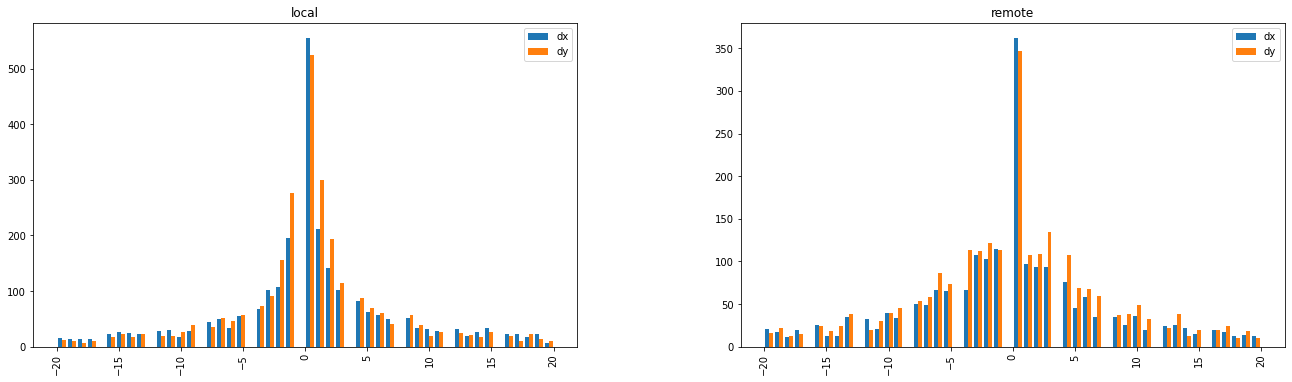

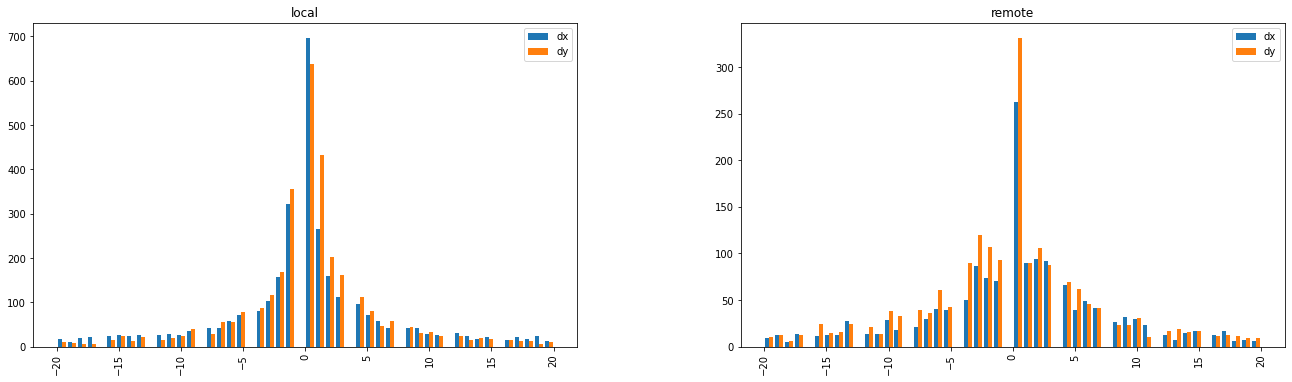

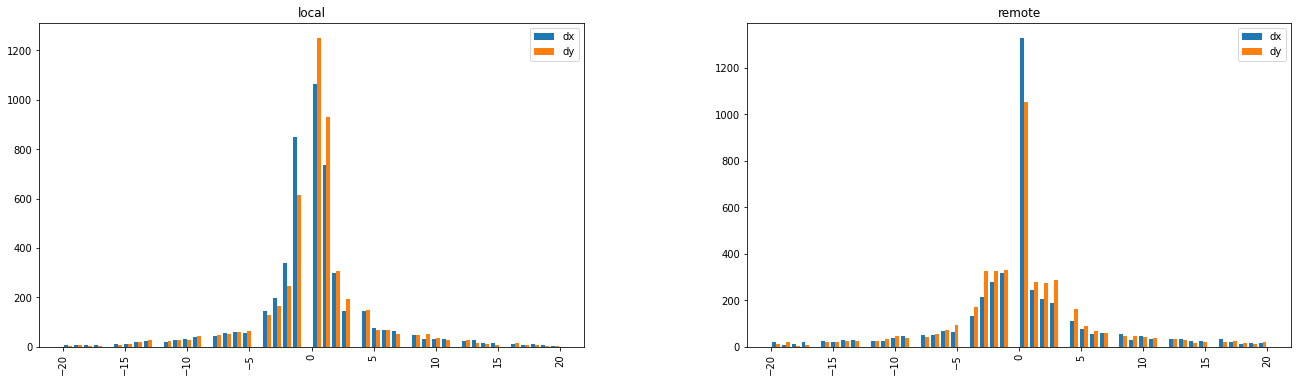

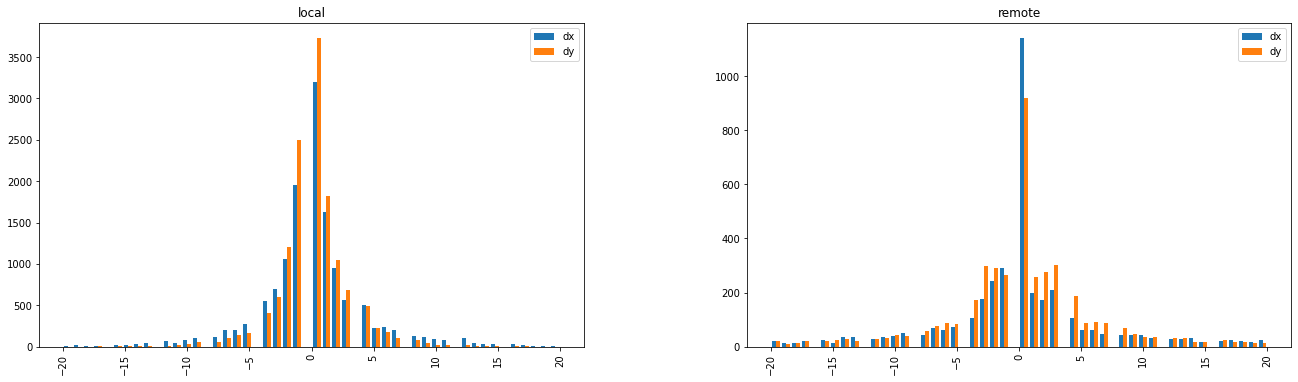

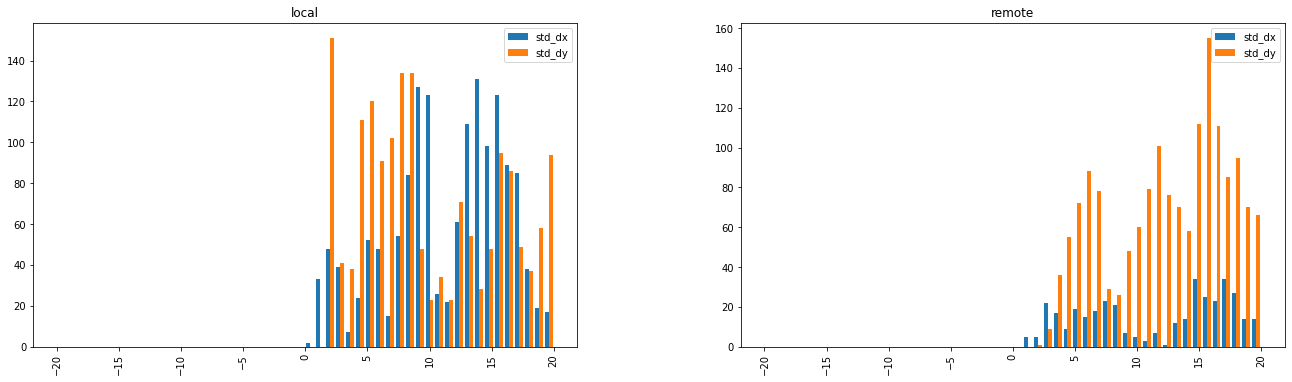

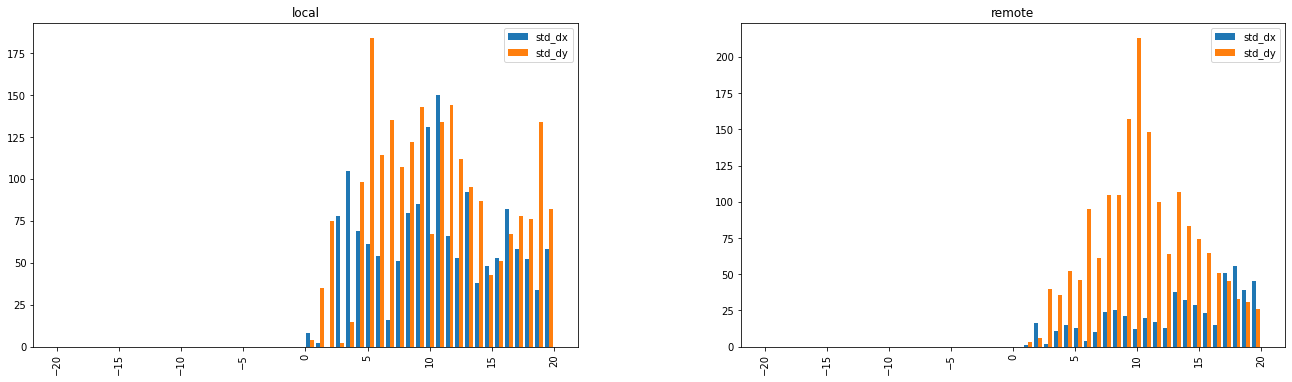

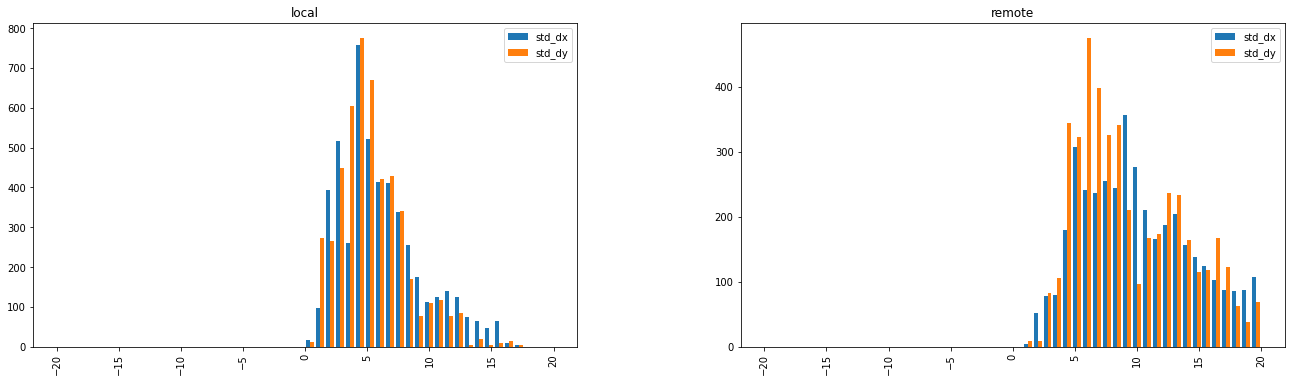

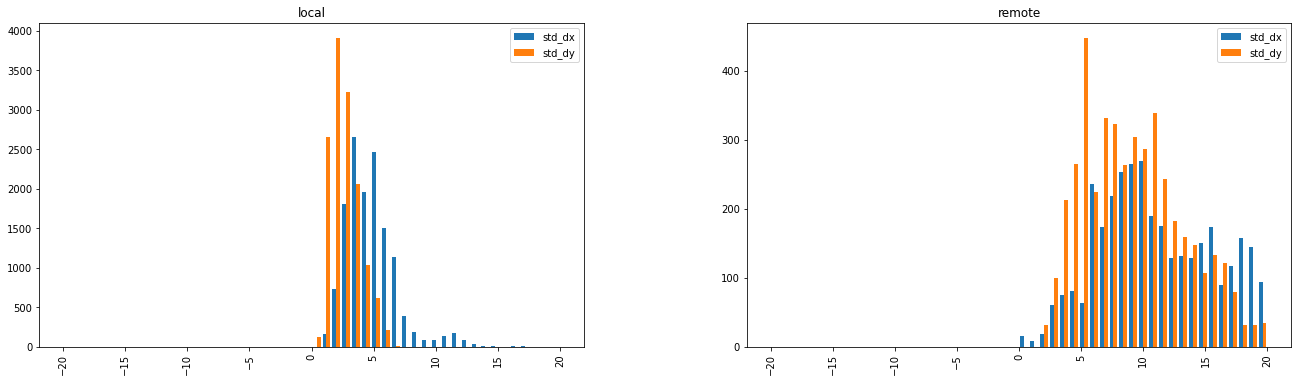

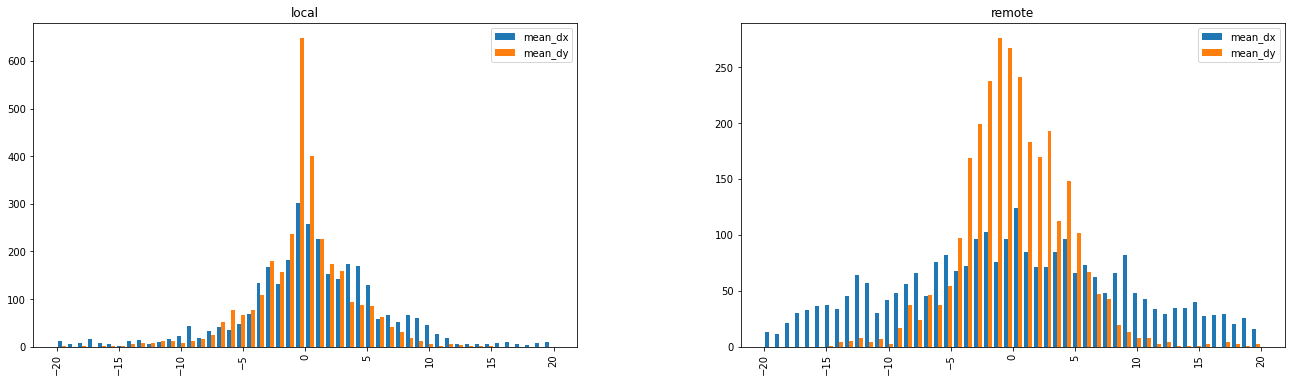

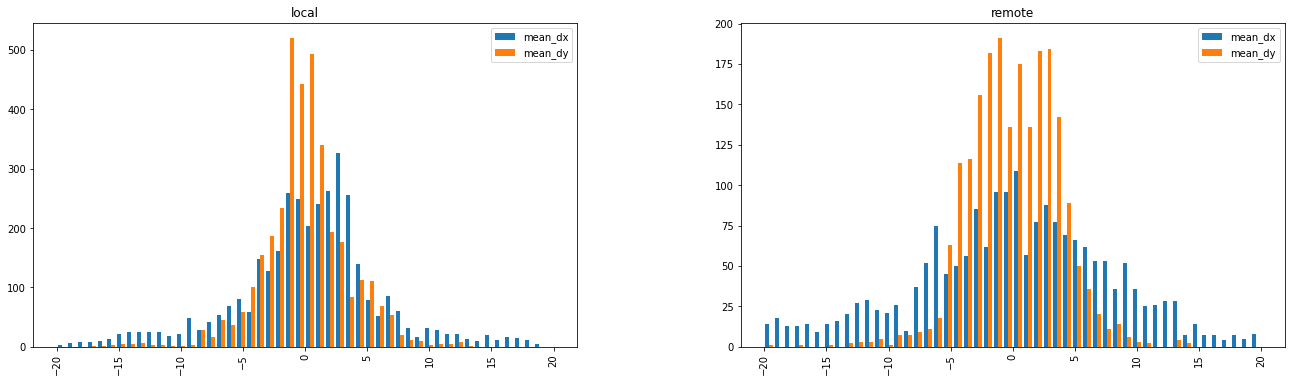

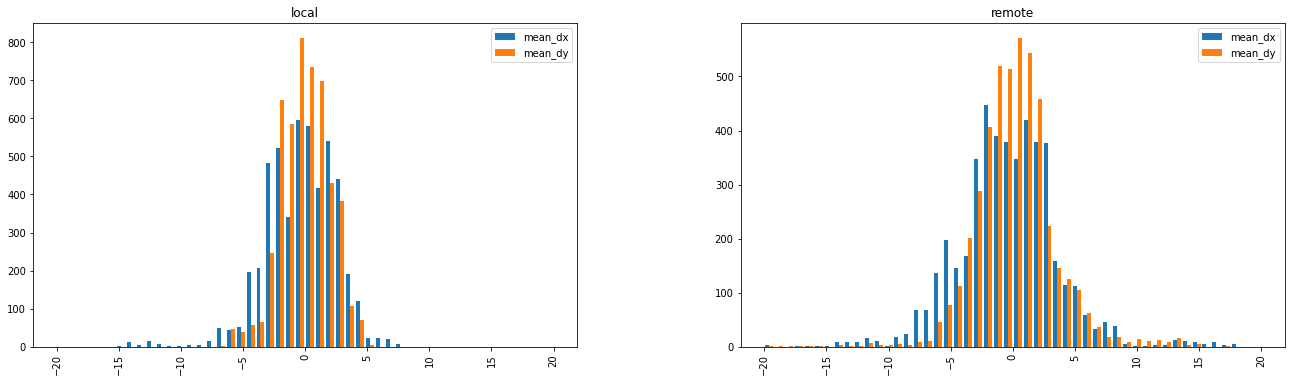

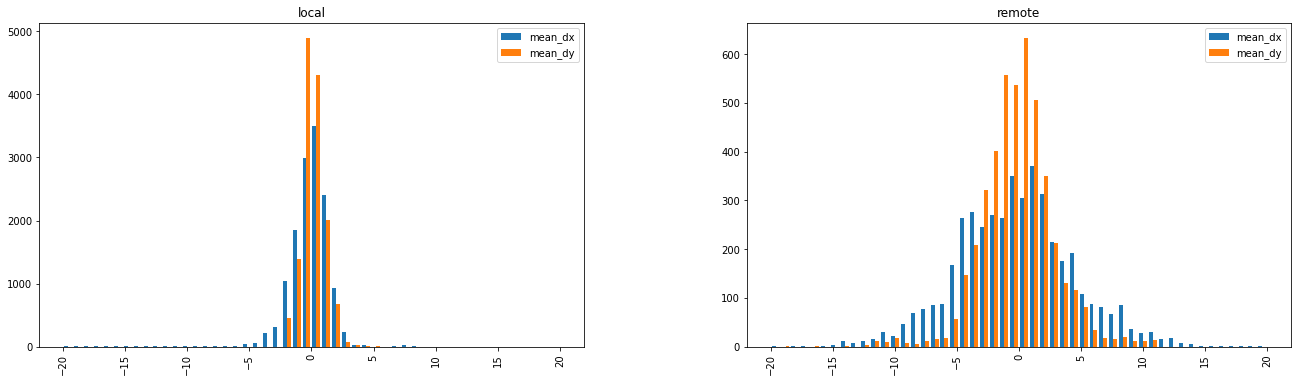

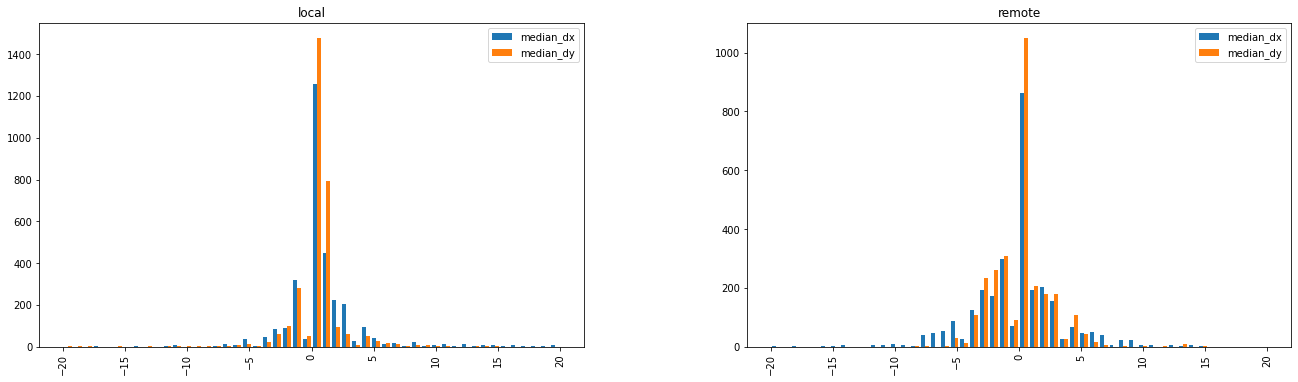

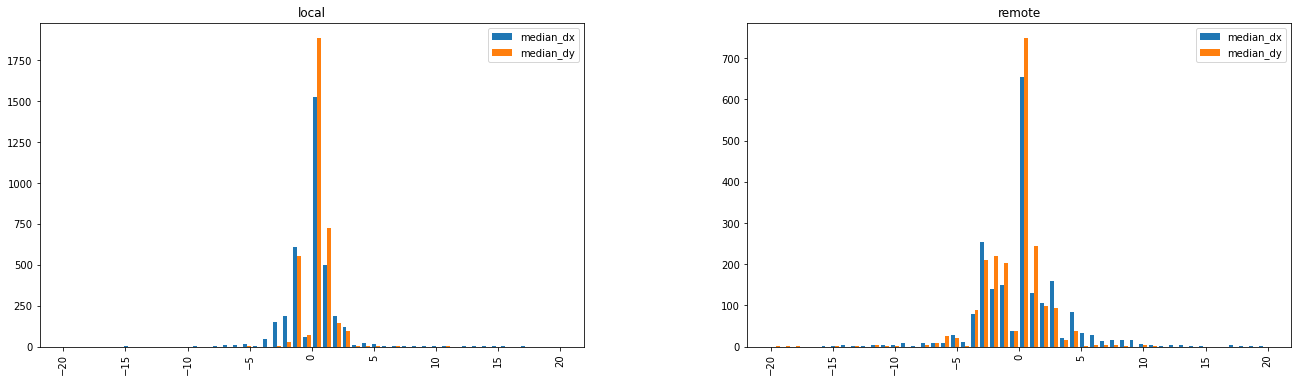

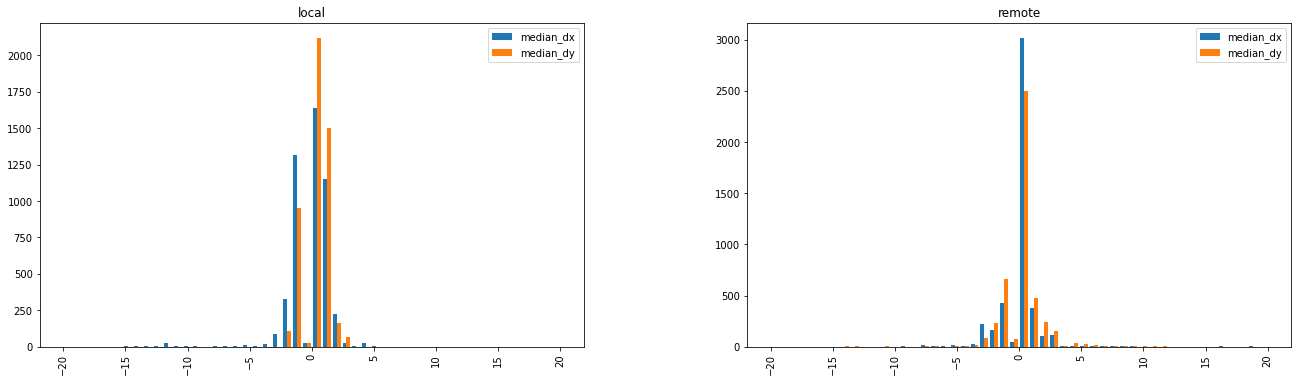

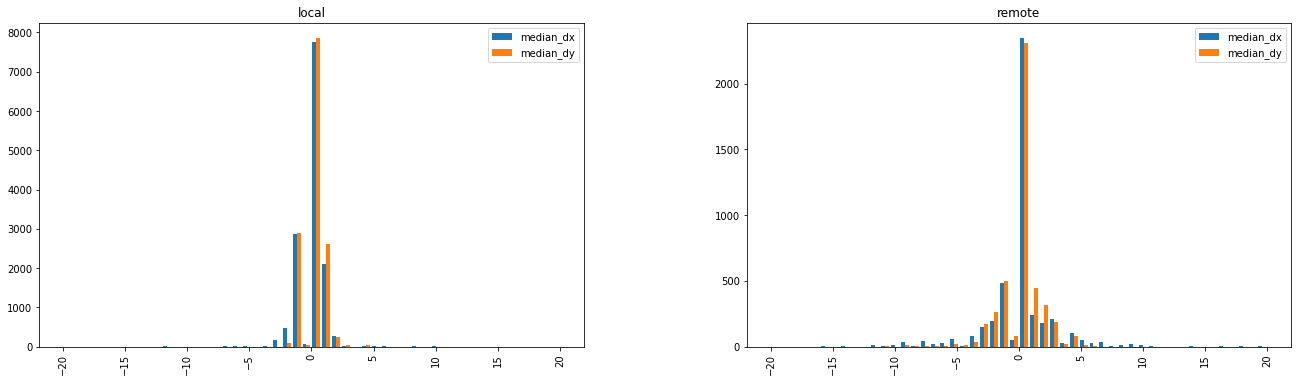

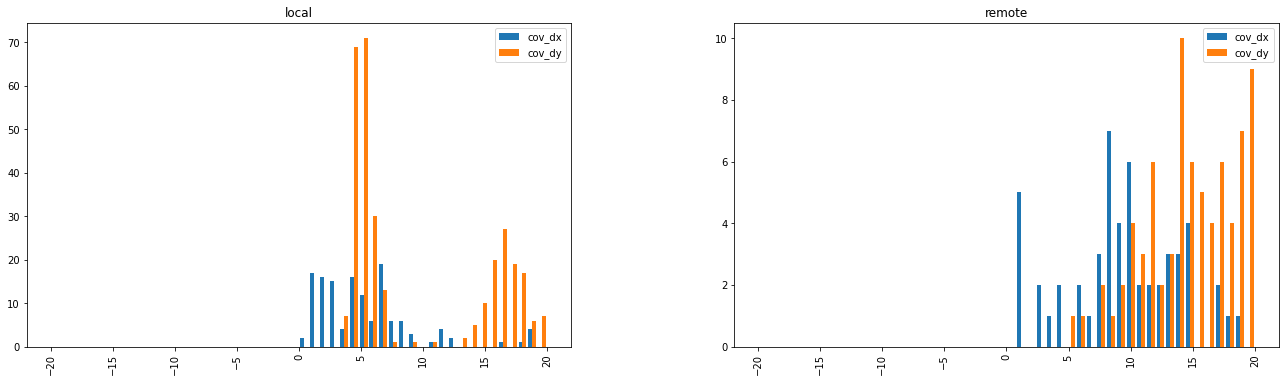

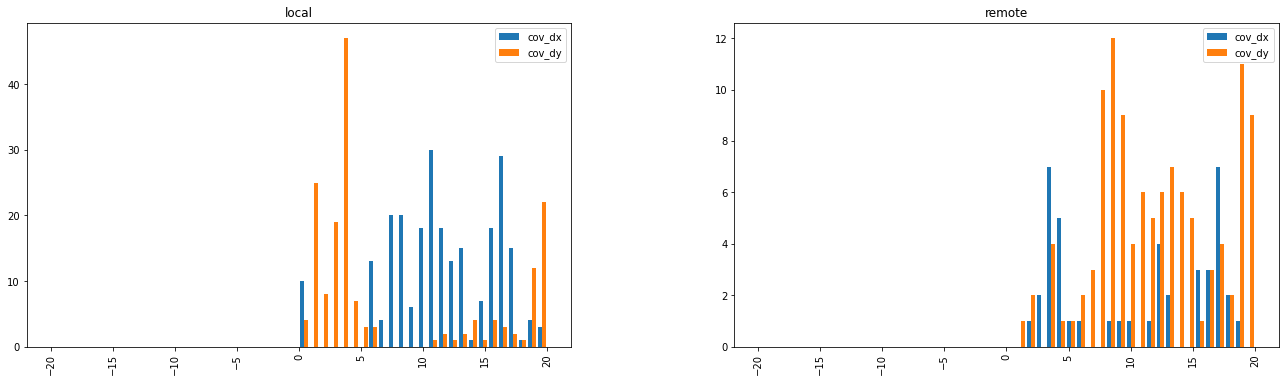

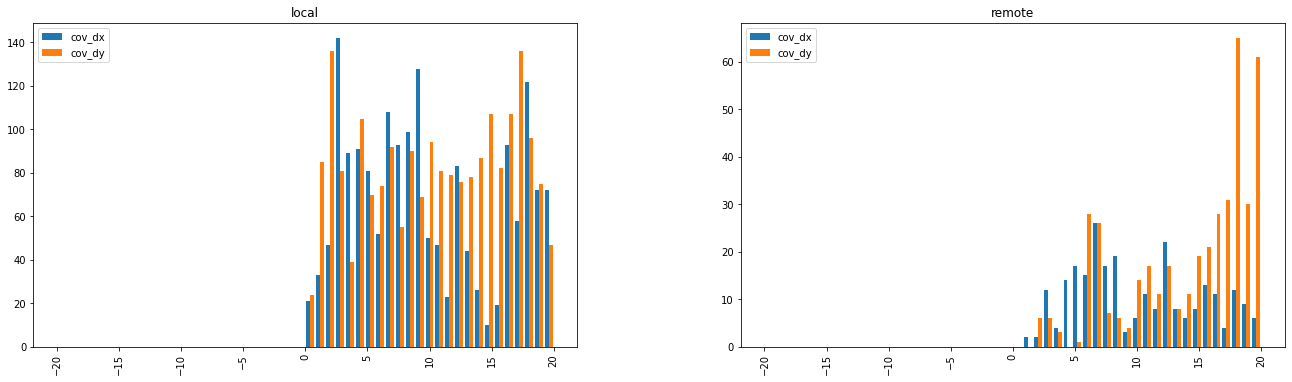

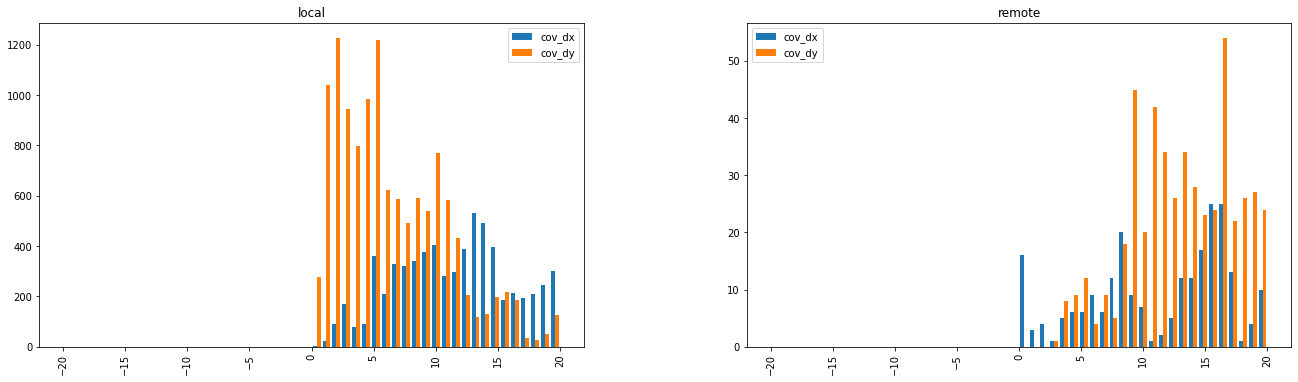

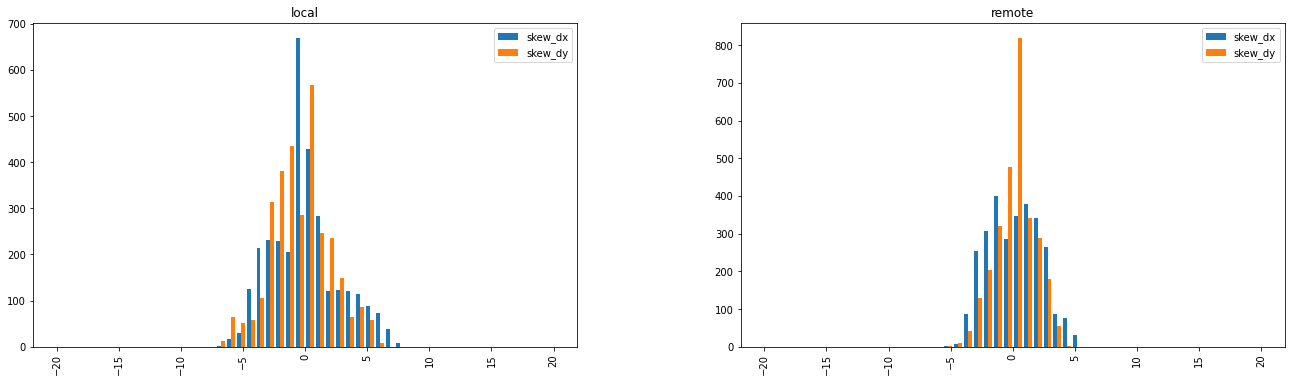

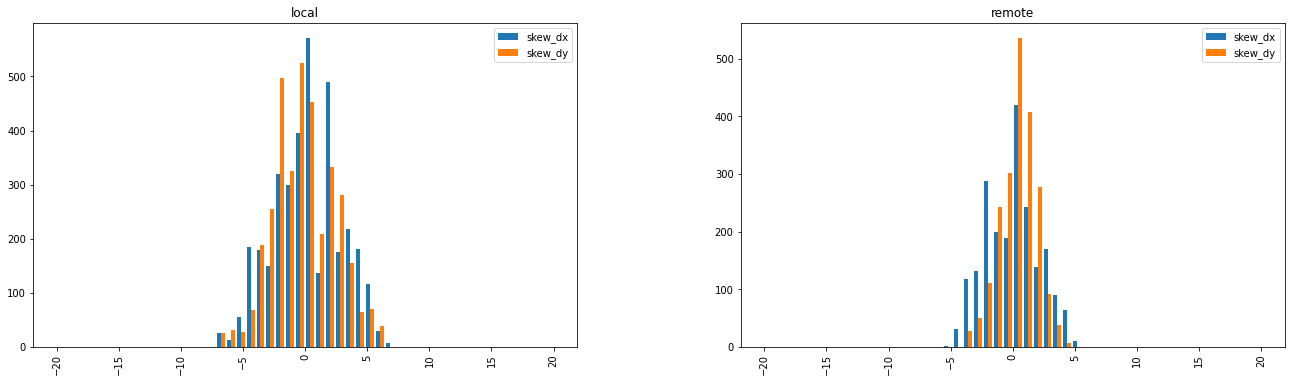

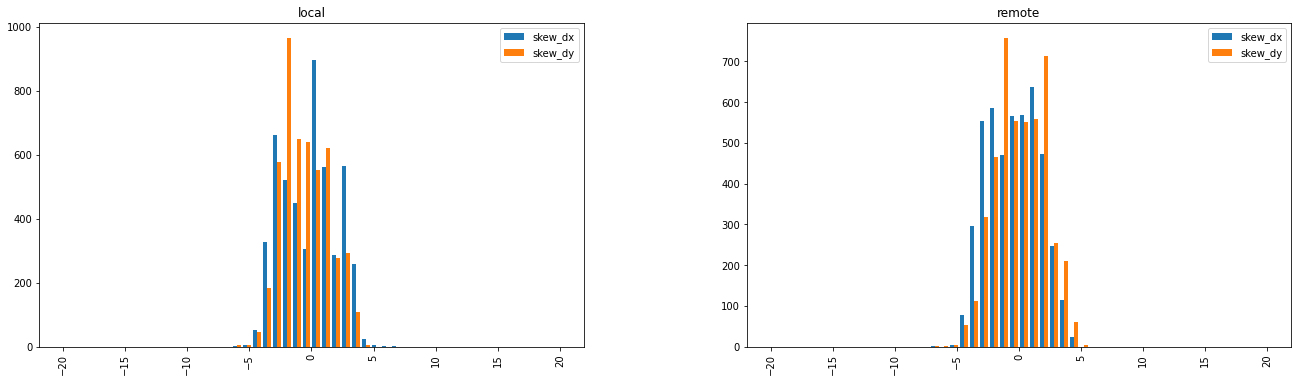

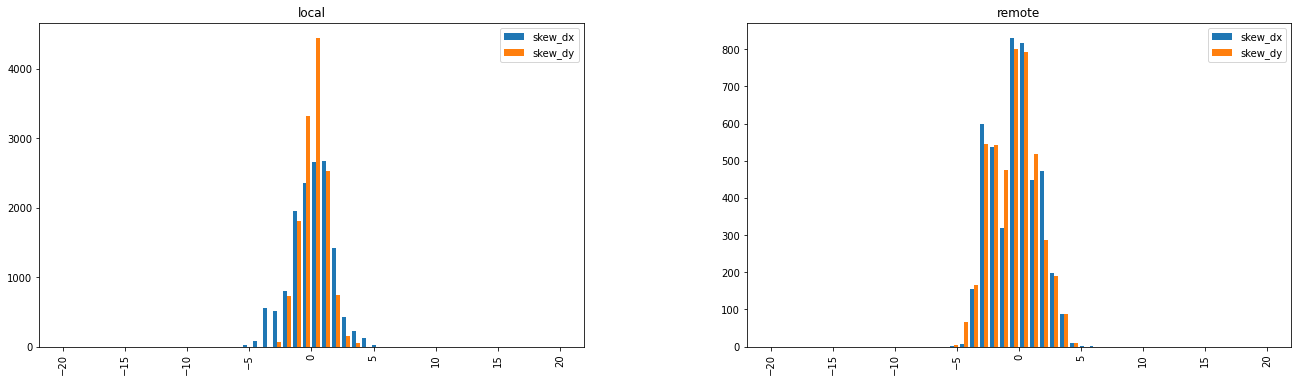

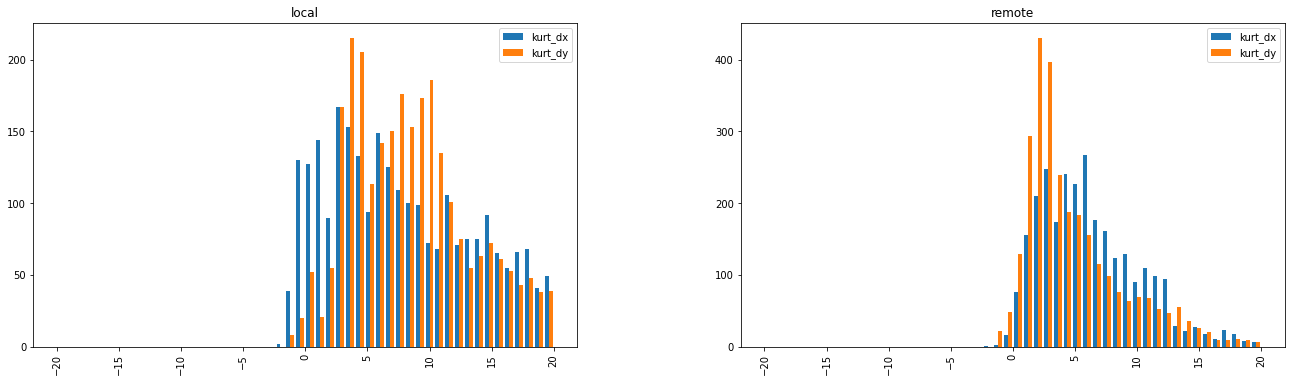

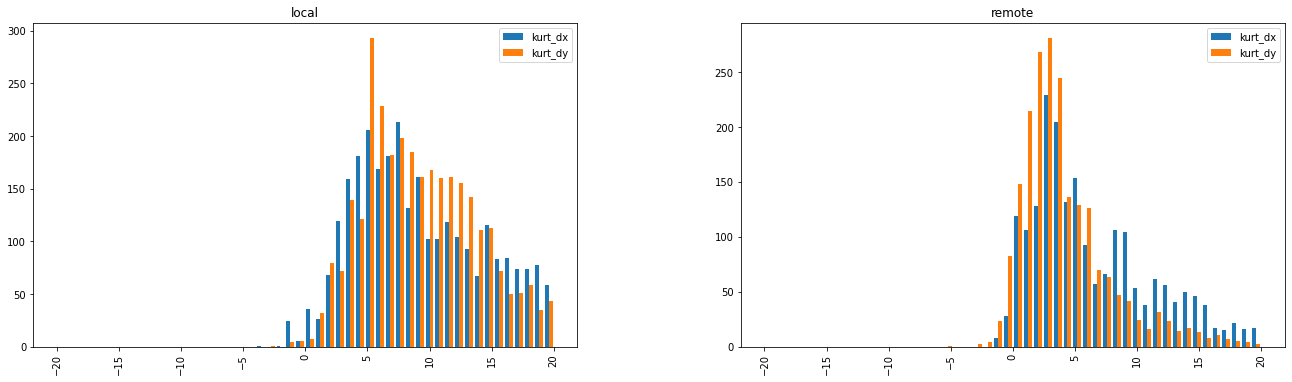

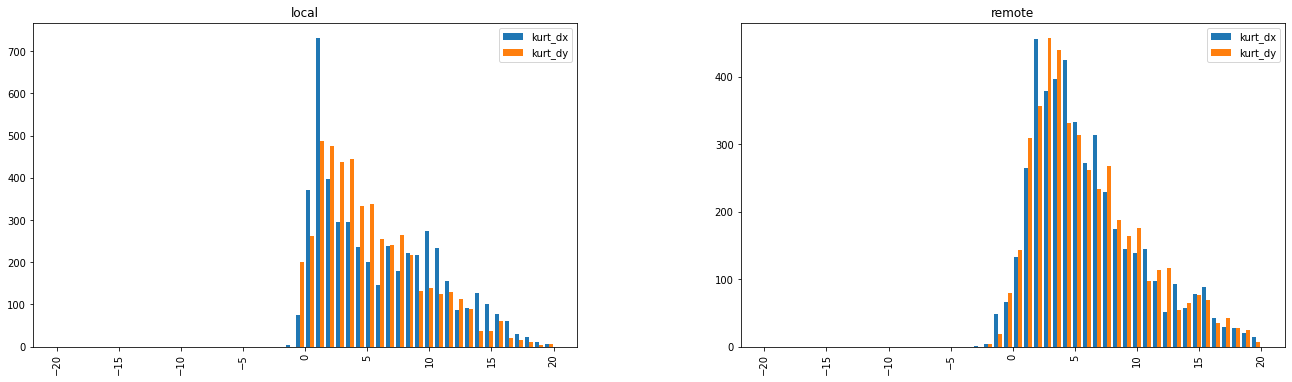

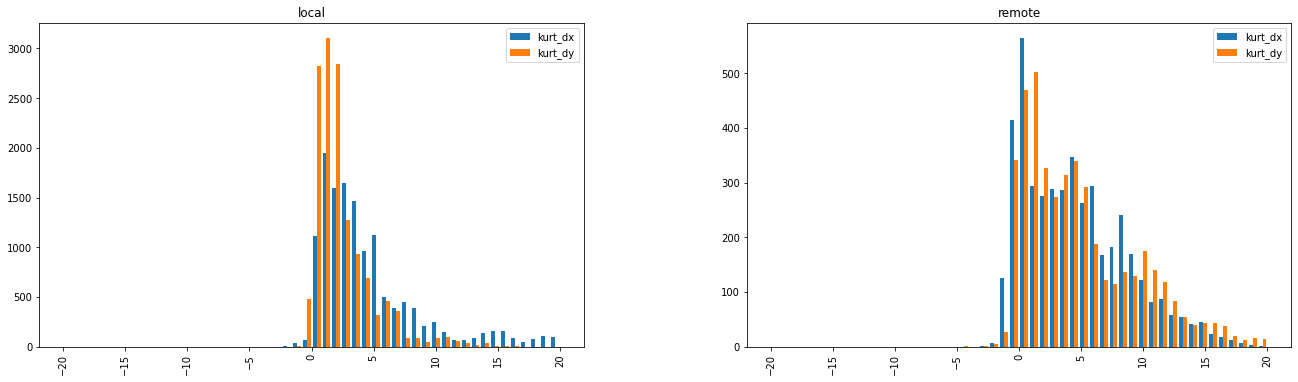

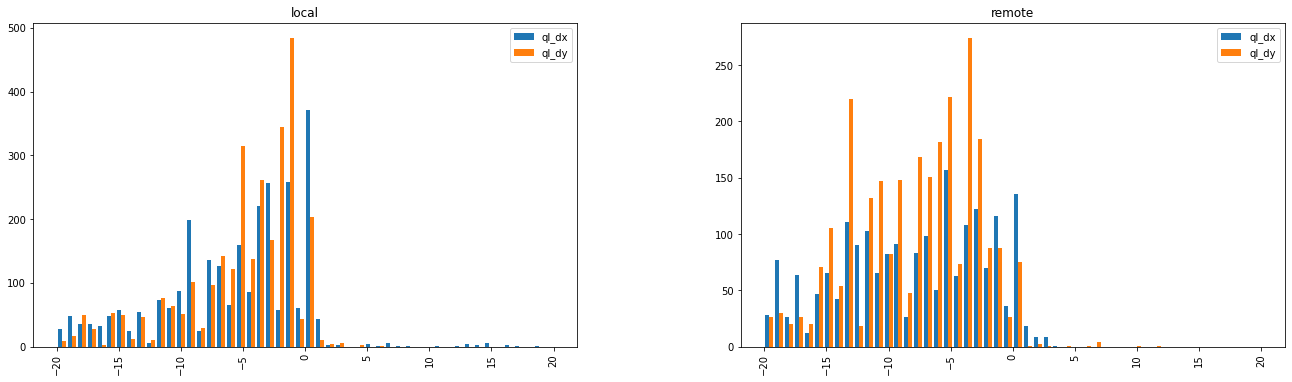

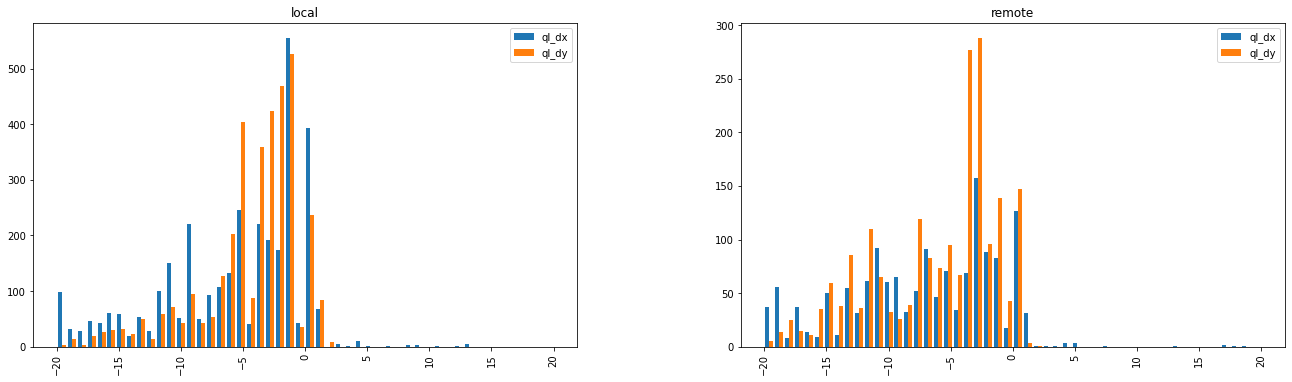

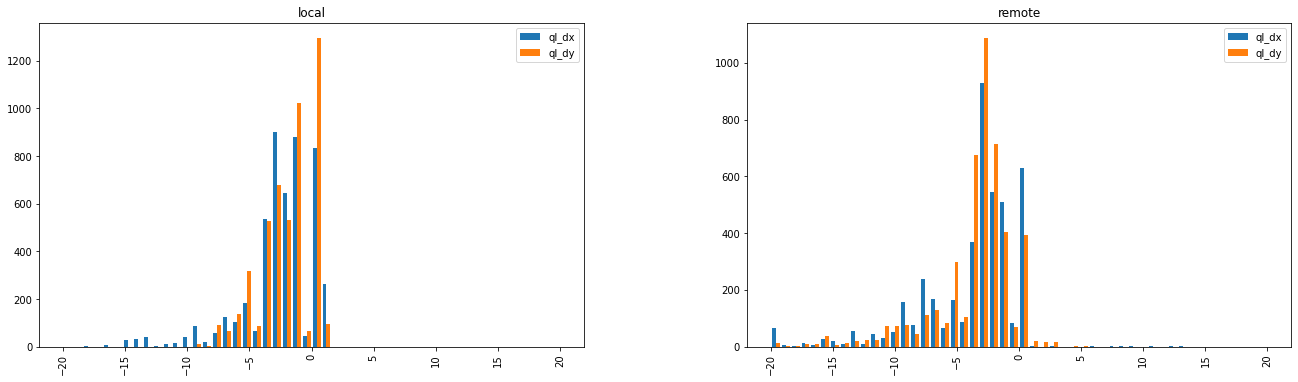

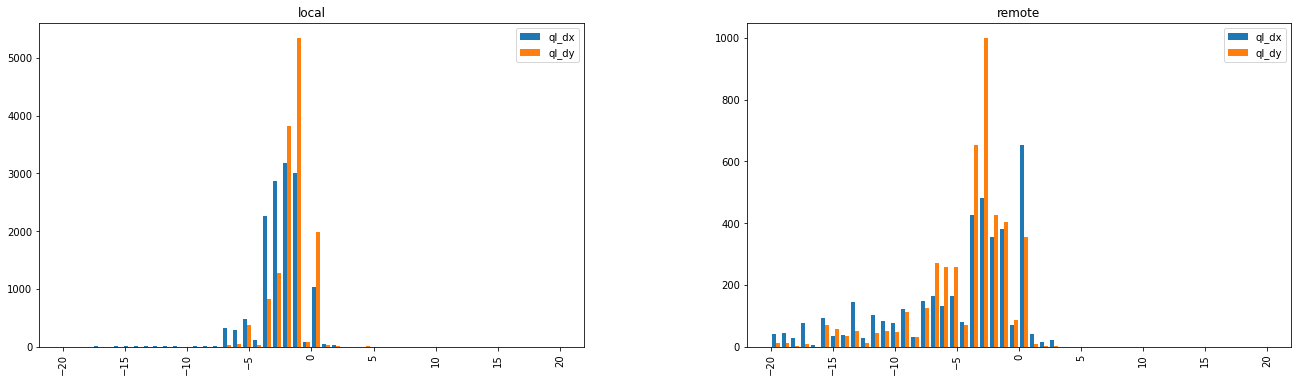

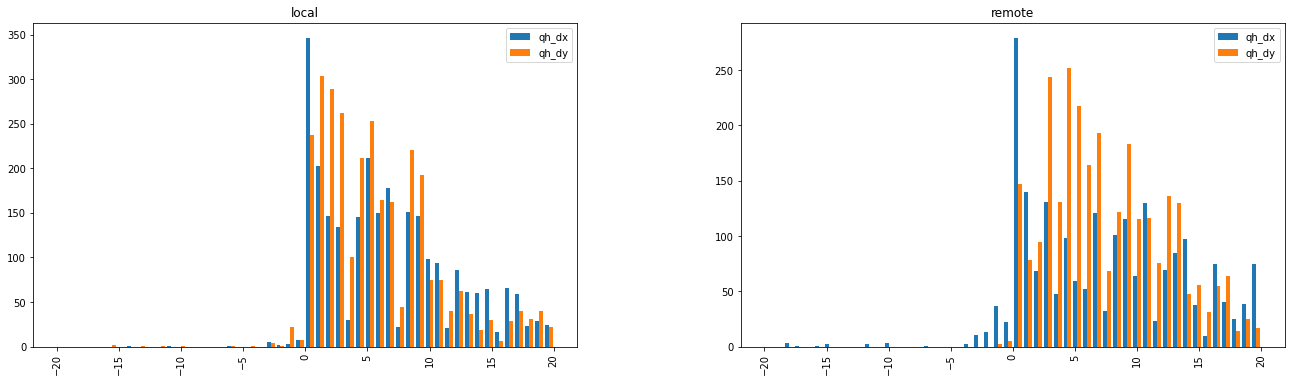

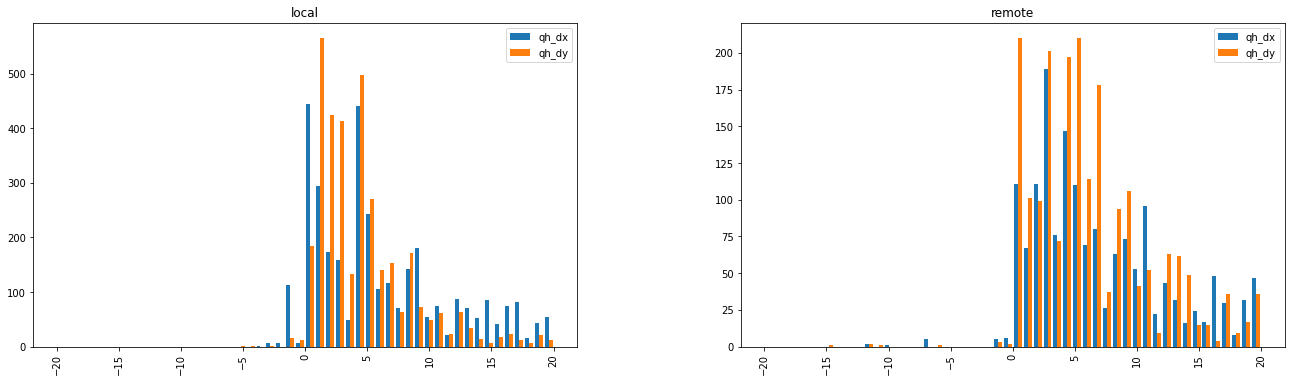

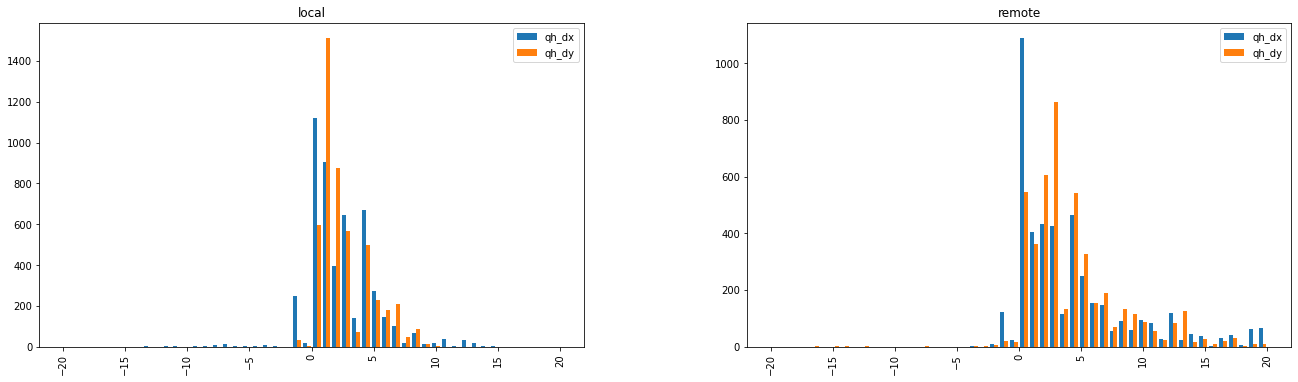

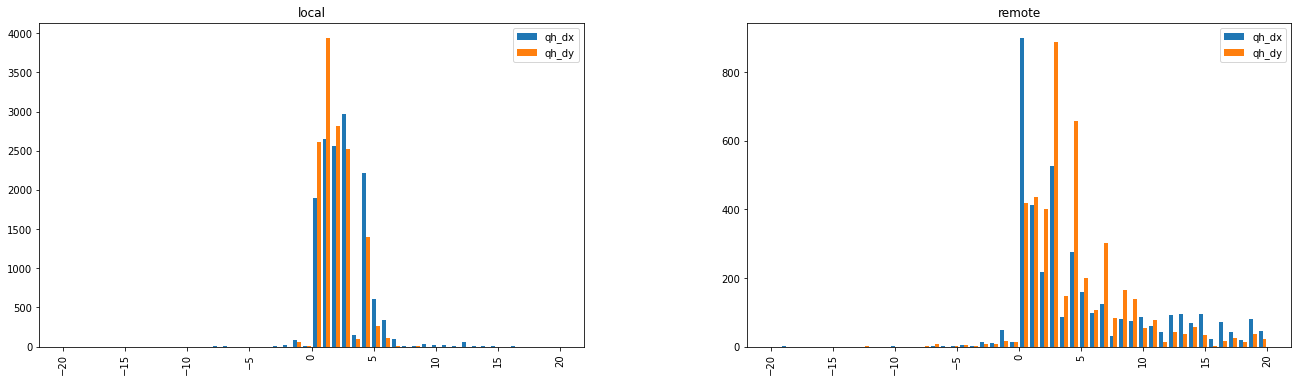

In [ ]:
 vd = [ 
        ['dx',        'dy',        'session', 'sid'],
        ['std_dx',    'std_dy',    'session', 'sid'],
        ['mean_dx',   'mean_dy',   'session', 'sid'],
        ['median_dx', 'median_dy', 'session', 'sid'],
        ['cov_dx',    'cov_dy',    'session', 'sid'],
        ['skew_dx',   'skew_dy',   'session', 'sid'] ,
        ['kurt_dx',   'kurt_dy',   'session', 'sid'], 
        ['ql_dx',     'ql_dy',     'session', 'sid'] ,
        ['qh_dx',     'qh_dy',     'session', 'sid'] ,
       
      ]
for mask in vd :
  mdp[mask].groupby('sid').hist(layout=(1,10),figsize=(120,6),bins=50,by='session',legend=True,range=[-20,20])
  plt.show()


## Analiza częstości próbkowania

Sprawdzam ile danych pomiarowych przeciętnie mieści się w oknach czasowych np 5s, 10s, 30s, dla sesji remote i local

Poniżej znajdują się wykresy pokazujące ilość próbek pozycji myszy w oknie czasowym. Okno przesuwane jest w sposób ciągły.

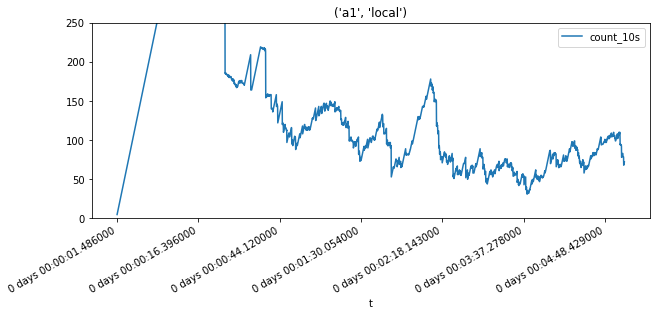

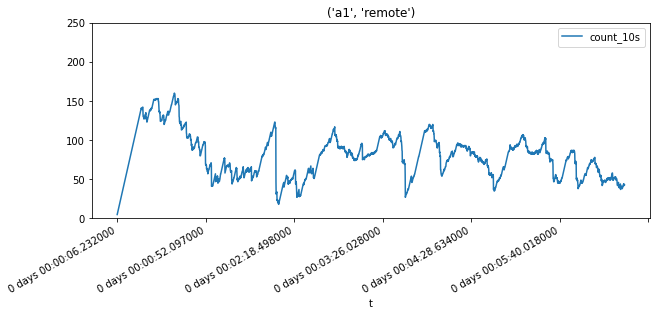

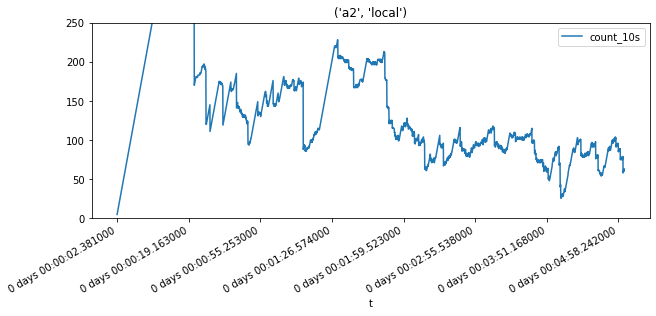

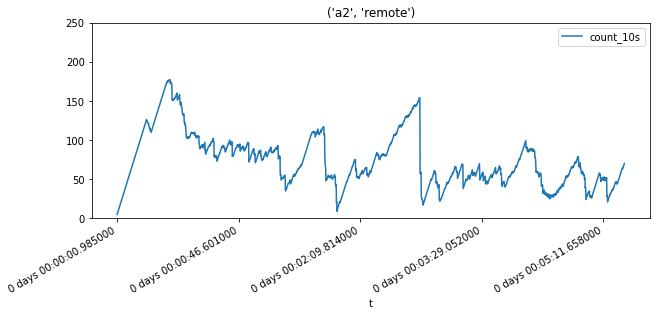

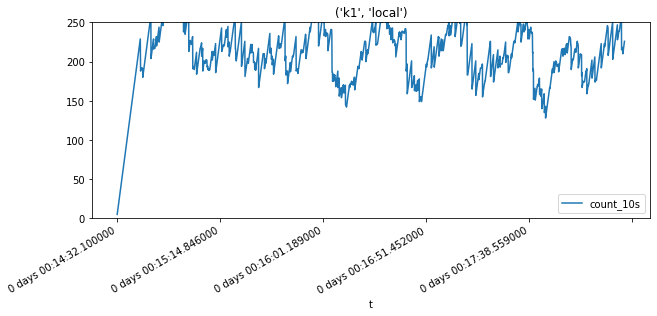

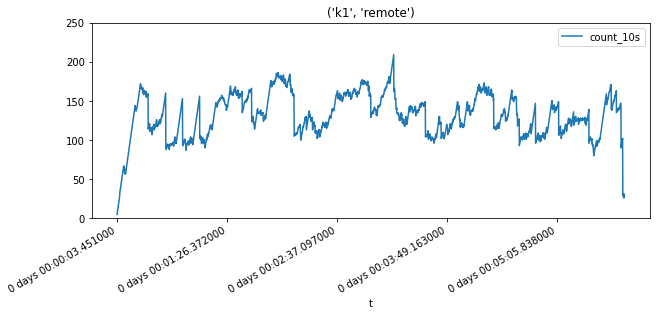

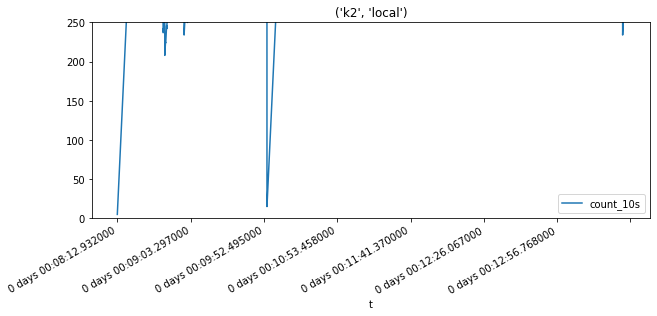

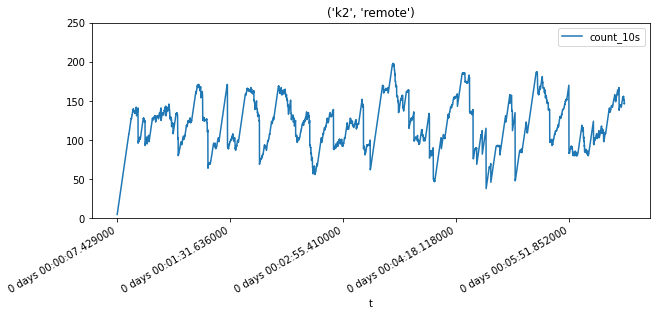

In [ ]:
for name, g in mdp.groupby(['sid','session']):
  g.plot(  kind='line', y='count_10s', title=str(name), ylim=(0,250),figsize=(10,4))

Ten wykres przedstawia sesje z linią trendu

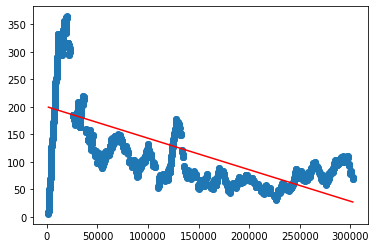

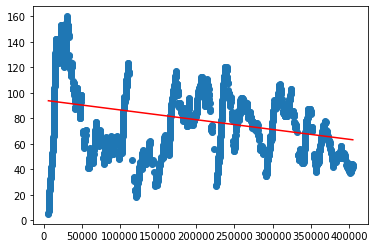

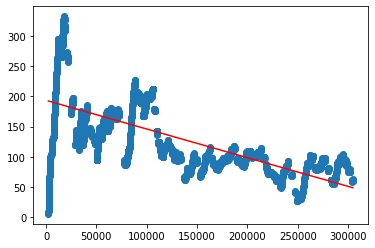

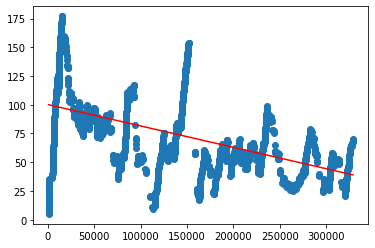

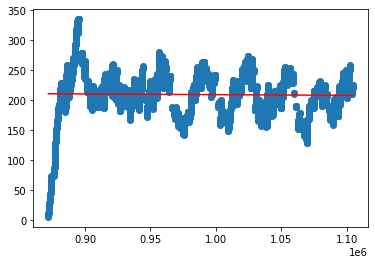

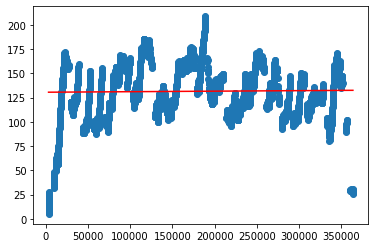

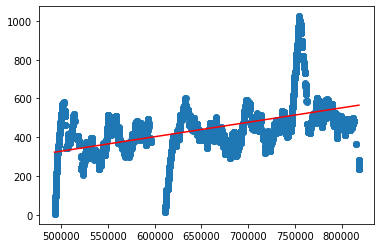

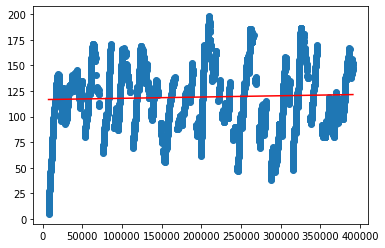

In [ ]:
for name, data in mdp.groupby(['sid','session']):
  # Regresion
  X = data.t_int.values.reshape(-1, 1)  # values converts it into a numpy array
  Y = data.count_10s.fillna(0).values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
  linear_regressor = LinearRegression()  # create object for the class
  linear_regressor.fit(X, Y)  # perform linear regression
  Y_pred = linear_regressor.predict(X)  # make predictions
  # Plot
  plt.scatter(X, Y)
  plt.plot(X, Y_pred, color='red')
  plt.show()



Ponizszy zestaw wykresów porównuje linie trendu tej samej sesji dla podłączenia zdalnego i lokalnego.

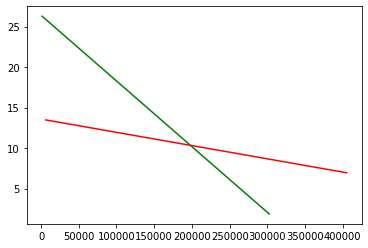

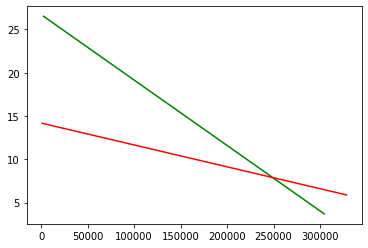

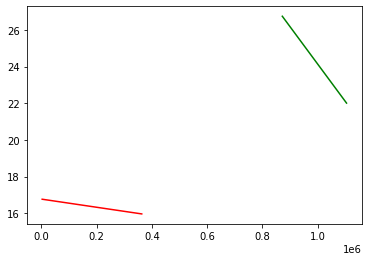

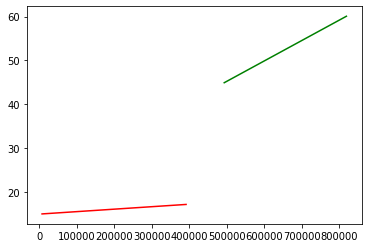

In [ ]:
def reg(data):
  X = data.t_int.values.reshape(-1, 1)  # values converts it into a numpy array
  Y = data.count_1s.fillna(0).values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
  linear_regressor = LinearRegression()  # create object for the class
  linear_regressor.fit(X, Y)  # perform linear regression
  Y_pred = linear_regressor.predict(X)  # make predictions
  return (X,Y,Y_pred)

for name, sidg in mdp.groupby(['sid']):
  data_l = sidg.groupby('session').get_group('local')
  data_r = sidg.groupby('session').get_group('remote')
  lreg = reg(data_l)
  rreg = reg(data_r)
  # Plot
  plt.plot(lreg[0], lreg[2], color='green')
  plt.plot(rreg[0], rreg[2], color='red')
  plt.show()

porównanie na jednym wykresie lini trendu sesji zdalnych i lokalnych

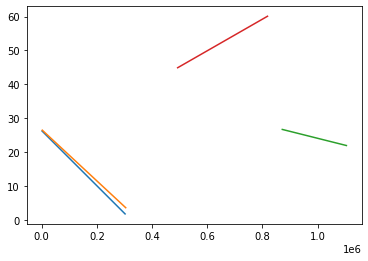

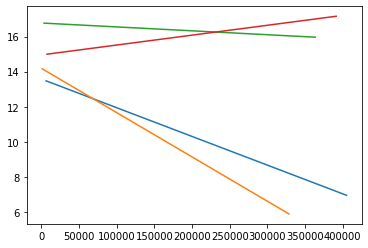

In [ ]:
for name, session_df in mdp.groupby(['session']):
  for name, sid_df in session_df.groupby(['sid']):
    r = reg(sid_df)
    plt.plot(r[0], r[2])
  plt.show()

## zbiorcze mini histograamy

ValueError: ignored

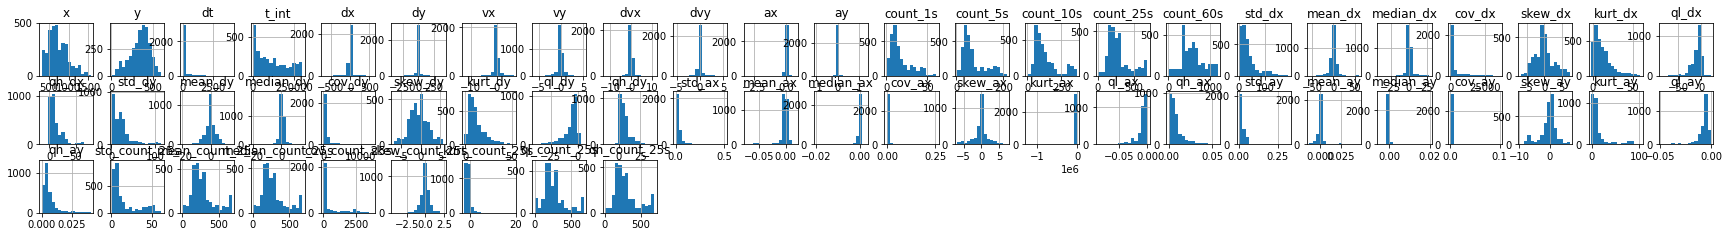

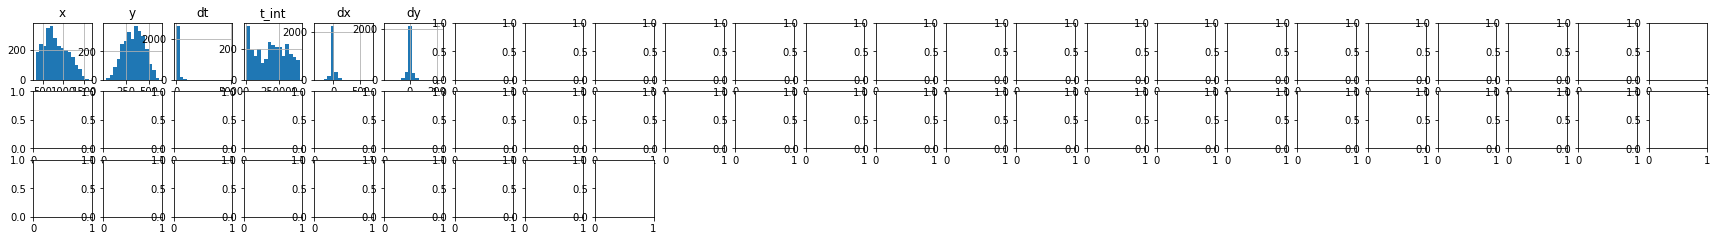

In [ ]:
mdp.groupby(['sid','session']).hist(layout=(24,24),figsize=(30,30),bins=15)

## zależność od czasu

In [ ]:
mdp.groupby(['sid','session']).plot(kind="line",y="std_dy")

# Nowa sekcja

# Badanie zmiany krzywizny rozkładu


## Przygotowanie danych

In [ ]:
# MAX_L='2m' # Maxymalna długość sesji
WIN_L='60s'

# Dla kazdego file obciać długość do MAX_L
# def timecut():

def winLabel(data):
  groups = data.group(['session','sid'])
  groupIter = iter(groups)
  for in groupIter.next():




## wizualne porównanie rozkładów dx, dy w małych oknach

Dla próbki local i remote generuję N histogramów dla danych o długości M.
Celem tego kroku jest sprawdzenie czy na poziomie małej rozdzielczości danych np 5s, 15s, 20s widoczne są różnice na wykresach tak jak dla zbiorczego histogramu w sekcji **Wykresy**.


In [ ]:
mdp.ro